# DATA MINING COURSE
## Graduate Program in Informatics (PPGIa) / PUCPR

PROFESSOR: Dr. Júlio César Nievola

ALUNOS: `LUCAS SANTOS TAVARES` - `tavares.lucas@gmail.com | lucas.tavares5@ppgia.pucpr.br | t.santos9@pucpr.edu.br`

            VINÍCIUS TERTULINO PAREDE - vinicius.parede1@gmail.com | vinicius.parede@ppgia.pucpr.br | vinicius.parede@pucpr.edu.br

# LIBRARIES TO BE USED

In [1]:
# To import dataset and manage using Githube.com ( https://github.com/viniciusparede/house-prices-prediction-ppgia )
import os
import git

# Data Manipulation
import pandas as pd
import numpy as np

# set the display option to show all columns
pd.set_option("display.max_columns", None)


import math
from scipy.stats import mode

# Machine Learning algorithmics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from skrebate import ReliefF
from sklearn.pipeline import make_pipeline
from skrebate import ReliefF
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


# Charts and visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

# Weka libraries
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier, Evaluation
from weka.attribute_selection import AttributeSelection
from weka.core.classes import Random

# Functions

In [2]:
# Função para encontrar diretório do repositório git
def get_git_root(path: str) -> str:
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root


def encode_categorical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converte atributos numéricos discretos de um DataFrame

    :param df: DataFrame do Pandas para conversão
    """
    # Instanciar um objeto LabelEncoder
    le = LabelEncoder()

    # Iterar sobre todas as colunas do DataFrame
    for col in df.columns:
        # Verificar se a coluna é do tipo "object", o que geralmente indica
        # uma coluna categórica com strings
        if df[col].dtype == "object":
            # Se for uma coluna categórica, use o LabelEncoder para ajustar
            # e transformar os dados, substituindo os valores originais
            # pelos valores codificados como números inteiros
            df[col] = le.fit_transform(df[col])

    # Retornar o DataFrame com as colunas categóricas codificadas
    return df


def pandas2arff(
    df, filename, wekaname="pandasdata", cleanstringdata=True, cleannan=True
):
    """
    converts the pandas dataframe to a weka compatible file
    df: dataframe in pandas format
    filename: the filename you want the weka compatible file to be in
    wekaname: the name you want to give to the weka dataset (this will be visible to you when you open it in Weka)
    cleanstringdata: clean up data which may have spaces and replace with "_", special characters etc which seem to annoy Weka.
                     To suppress this, set this to False
    cleannan: replaces all nan values with "?" which is Weka's standard for missing values.
              To suppress this, set this to False
    """
    import re

    def cleanstring(s):
        if s != "?":
            return re.sub("[^A-Za-z0-9]+", "_", str(s))
        else:
            return "?"

    dfcopy = df  # all cleaning operations get done on this copy

    if cleannan != False:
        dfcopy = dfcopy.fillna(
            -999999999
        )  # this is so that we can swap this out for "?"
        # this makes sure that certain numerical columns with missing values don't get stuck with "object" type

    # Diretório do repositório git
    git_dir = get_git_root(os.getcwd())

    # Diretório de arquivos de dados
    data_dir = os.path.join(git_dir, "data")

    f = open(os.path.join(data_dir, filename), "w")
    arffList = []
    arffList.append("@relation " + wekaname + "\n")
    # look at each column's dtype. If it's an "object", make it "nominal" under Weka for now (can be changed in source for dates.. etc)
    for i in range(df.shape[1]):
        if dfcopy.dtypes[i] == "O" or (df.columns[i] in ["Class", "CLASS", "class"]):
            if cleannan != False:
                dfcopy.iloc[:, i] = dfcopy.iloc[:, i].replace(
                    to_replace=-999999999, value="?"
                )
            if cleanstringdata != False:
                dfcopy.iloc[:, i] = dfcopy.iloc[:, i].apply(cleanstring)
            _uniqueNominalVals = [str(_i) for _i in np.unique(dfcopy.iloc[:, i])]
            _uniqueNominalVals = ",".join(_uniqueNominalVals)
            _uniqueNominalVals = _uniqueNominalVals.replace("[", "")
            _uniqueNominalVals = _uniqueNominalVals.replace("]", "")
            _uniqueValuesString = "{" + _uniqueNominalVals + "}"
            arffList.append("@attribute " + df.columns[i] + _uniqueValuesString + "\n")
        else:
            arffList.append("@attribute " + df.columns[i] + " real\n")
            # even if it is an integer, let's just deal with it as a real number for now
    arffList.append("@data\n")
    for i in range(dfcopy.shape[0]):  # instances
        _instanceString = ""
        for j in range(df.shape[1]):  # features
            if dfcopy.dtypes[j] == "O":
                _instanceString += '"' + str(dfcopy.iloc[i, j]) + '"'
            else:
                _instanceString += str(dfcopy.iloc[i, j])
            if j != dfcopy.shape[1] - 1:  # if it's not the last feature, add a comma
                _instanceString += ","
        _instanceString += "\n"
        if cleannan != False:
            _instanceString = _instanceString.replace(
                "-999999999.0", "?"
            )  # for numeric missing values
            _instanceString = _instanceString.replace(
                '"?"', "?"
            )  # for categorical missing values
        arffList.append(_instanceString)
    f.writelines(arffList)
    f.close()
    del dfcopy
    return True


def evaluation_to_dataframe(predictions: list) -> pd.DataFrame:
    # Criar lista de dicionários com informações de previsão e distribuição usando list comprehension
    prediction_dict_list = [
        {
            "predicted": nominal_prediction.predicted,
            "actual": nominal_prediction.actual,
            "distribution": nominal_prediction.distribution.tolist(),
            "weight": nominal_prediction.weight,
        }
        for nominal_prediction in predictions
    ]

    # Gerar dataframe pandas a partir da lista de dicionários
    predictions_df = pd.DataFrame(prediction_dict_list)

    # Adicionar coluna que indica se a previsão foi correta ou não
    predictions_df["correct"] = predictions_df["predicted"] == predictions_df["actual"]

    return predictions_df

# LOAD DATA SET

In [3]:
# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório dos dados
data_dir = os.path.join(git_dir, "data")

# Leitura dos arquivos de treinamento e teste
df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))

In [4]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# GROUP OF QUESTIONS #1:
# DATASET DESCRIPTION (DESCRIÇÃO DA BASE DE DADOS)

1.1) Indicar o nome da base:

House Prices ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/rules )


1.2) Que tipo de dado (ou problema) caracteriza esta base de dados, ou seja, o que se pretende extrair de conhecimento a partir dos dados lá disponíveis (classificação/regressão, agrupamento, associação, por exemplo):

Classificação/regressão e agrupamento


1.3) Indicar quem forneceu esta base, além da data da coleta dos dados (início e final), além de particularidades (por exemplo, a coleta foi interrompida durante um período de tempo e depois retomada):

O próprio site da Kaggle forneceu a base de dados como forma de competição. Mesmo analisando os metadados da base e o arquivo “data_description.txt”, não foi possível identificar a data de coleta dos dados e a data de criação da base de dados


1.4) Indicar se existem informações já publicadas sobre seu uso e, em caso positivo, onde foi publicado, por quem, o quê:

Sim, há publicações prévias e devido ao fato da base ser uma base de competição, existem vários notebooks já publicados, no próprio site do Kaggle ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/code?competitionId=5407&sortBy=scoreAscending )



1.5) Quantas classes existem e quais são elas, no caso de classificação, ou o nome e a faixa de valores da variável a ser prevista no caso de regressão:

Existem 81 classes/colunas/atributos no arquivo com diversos tipos de variáveis.  numéricas (sejam intervalos ou ratios) e categóricas (nominais ou ordinais). As faixas de valores e tipos de variáveis podem ser vistos no arquivo "data_description.txt".




# GROUP OF QUESTIONS #2:
# DATASET FEATURES (CARACTERÍSTICAS DA BASE DE DADOS)

There are 14 question in this group and each question will be in it own markdown field below.

2.1) Quantas instâncias existem?

Existe 1460 instâncias, conforme código abaixo.


2.2) Quantos atributos existem?

Existem 81 atributos/colunas, conforme código abaixo.

In [5]:
print(df_train.shape) #Check size of df_train

(1460, 81)


2.3) O tipo de cada atributo?

Vide na lista (Dtype) e no gráfico abaixo, sendo que "int64" e "float64" são variáveis numéricas e "objects" são variáveis categóricas.

In [6]:
df_train.info() #Check the df_train properties, including the type of each atribute/column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

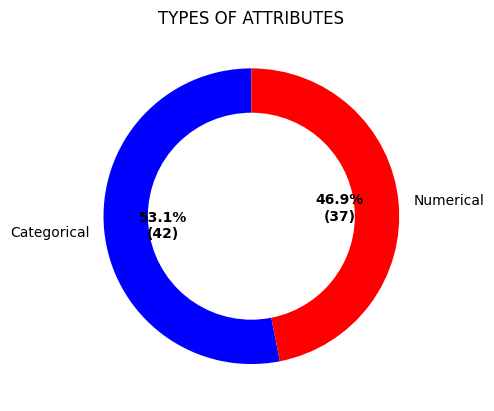

In [7]:
# ACCOUNTING THE TYPES OF ATTRIBUTES

dtypes_count = df_train.dtypes.replace(
    {"float64": "Numerical", "int64": "Numerical", "object": "Categorical"}
).value_counts()

### Create a chart to show it
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ["blue", "red"]

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sizes.sum())})",
    startangle=90,
)
plt.setp(autotexts, size=10, weight="bold")
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)
plt.title("TYPES OF ATTRIBUTES", loc="center")
plt.show()
### ENF OF Create a chart to show it

2.4) Há informações sobre ruído? Em caso positivo, quais?

Não existem ruídos propriamente ditos, pois esta base não se trata de uma série temporal.
Foram identificados colunas onde um valor NULL ou n/a preenchido não significa vazio e sim que tal atributo pode ser zero ou não existe na casa. Exemplo: PoolQC (Qualidade da Piscina), onde um valor NULL em sua célula significa que não há piscina naquela casa:

        PoolQC: Pool quality
                
            Ex	Excellent
            Gd	Good
            TA	Average/Typical
            Fa	Fair
            NA	No Pool


Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.


In [8]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = df_train.isnull().sum()[df_train.isnull().sum() > 0]
missing_data_percentage = missing_data / len(df_train) * 100

# Combinar as informações em um dataframe
df_train_missing_values = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
df_train_missing_values = df_train_missing_values.sort_values(
    by="Percentage", ascending=False
)

df_train_missing_values

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [9]:
# FILL MISSING VALUES AND CHECK AGAIN

# Lista de colunas que precisam ser preenchidas com "NA"
cols_to_fillna = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtExposure",
    "BsmtFinType2",
    "BsmtFinType1",
    "BsmtCond",
    "BsmtQual",
]

df_train_filled = df_train.copy()

# Usando uma compreensão de lista para preencher os valores ausentes com "NA" em cada coluna
for col in cols_to_fillna:
    df_train_filled[col].fillna("NA", inplace=True)

# Preenchendo os valores ausentes no atributo "LotFrontage" com o valor padrão "0"
df_train_filled["LotFrontage"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "GarageYrBlt" com o valor padrão "0"
df_train_filled["GarageYrBlt"].fillna(0, inplace=True)

# Excluindo as instâncias com valores ausentes (conjunto pequeno em relação ao tamanho do conjunto de dados)
cols_to_dropna = ["MasVnrArea", "Electrical"]
df_train_filled.dropna(subset=cols_to_dropna, inplace=True)

# Excluir coluna Id
df_train_filled.drop(columns="Id", inplace=True)

df_train_filled.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


2.5) Há indicação de outliers?

Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.

Sim. Dado a dimensão dessa base de dados seria estranho se algum dos 80 atributos não apresentassem outliers. Abaixo segue um exemplo onde o Preço de Vendas (SalePrice) é confrontrado, em boxplot, com outras variáveis como Vizinhança (Neighborhoo), Condição Geral do Imóvel (OverallCond) e Qualidade Geral do imóvel (OverallQual).

In [10]:
# CHECK OUTLIERS

# First, split the columns in two groups: Categorical and Numerical
numericos = list(df_train.select_dtypes(include=["int64", "float64"]).columns)
categoricos = list(df_train.select_dtypes(include=["object"]).columns)
print("### THE NUMERICAL COLUMNS ARE:")
print(numericos)
print("\n### THE CATEGORICAL COLUMNS ARE:")
print(categoricos)
print(f"\nTOTAL COLUMNS ANALYZED ARE: {len(numericos) + len(categoricos)}")

### THE NUMERICAL COLUMNS ARE:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

### THE CATEGORICAL COLUMNS ARE:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',

In [11]:
# Transformar variaveis categoricas em variaveis numéricas discretas
df_train_filled_encoded = encode_categorical(df_train_filled)

df_train_filled_encoded.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,3,65.0,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,4,4,2,706,6,0,150,856,1,0,1,4,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,1,2003.0,2,2,548,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4,208500
1,20,3,80.0,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,3,0.0,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,4,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,1,1976.0,2,2,460,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4,181500
2,60,3,68.0,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,4,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,1,2001.0,2,2,608,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4,223500
3,70,3,60.0,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,3,0.0,3,4,0,4,1,4,0,216,6,0,540,756,1,2,1,4,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.0,3,3,642,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0,140000
4,60,3,84.0,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,4,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,1,2000.0,2,3,836,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4,250000


In [12]:
# CALCULATE OUTLIERS

# Calculate IQR per column
q1 = df_train_filled_encoded.quantile(0.25)
q3 = df_train_filled_encoded.quantile(0.75)
iqr = q3 - q1
# END OF Calculate IQR per column

# According the IQ Method, outliers are those values above or below of 1.5*IQR
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr
# According the IQ Method, outliers are those values above or below of 1.5*IQR

# Identifica as colunas com outliers
outlier_columns = df_train_filled_encoded.columns[
    (df_train_filled_encoded > upper_threshold).any()
]
outlier_columns = df_train_filled_encoded.columns[
    (df_train_filled_encoded < lower_threshold).any()
]
outlier_column_names = outlier_columns.tolist()

# Imprime a lista de colunas com outliers
print("### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:")
outlier_categorical_columns = [
    item for item in categoricos if item in outlier_column_names
]
print(outlier_categorical_columns)
print(
    f"TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_categorical_columns)} of {len(categoricos)}"
)
print("\n### NUMERICAL COLUMNS WITH OUTLIERS VALUES:")
outlier_numerical_columns = [item for item in numericos if item in outlier_column_names]
print(outlier_numerical_columns)
print(
    f"TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_numerical_columns)} of {len(numericos)}"
)
print(
    f"\n\nTOTAL COLUMNS WITH OUTLIERS VALUES: {len(outlier_column_names)} of {len(df_train.columns)} ({round(len(outlier_column_names)/len(df_train.columns)*100,1)}%)"
)
print("#############")
print(outlier_numerical_columns)

### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:
['MSZoning', 'Street', 'Alley', 'LandContour', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 28 of 43

### NUMERICAL COLUMNS WITH OUTLIERS VALUES:
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 8 of 38


TOTAL COLUMNS WITH OUTLIERS VALUES: 36 of 81 (44.4%)
#############
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']


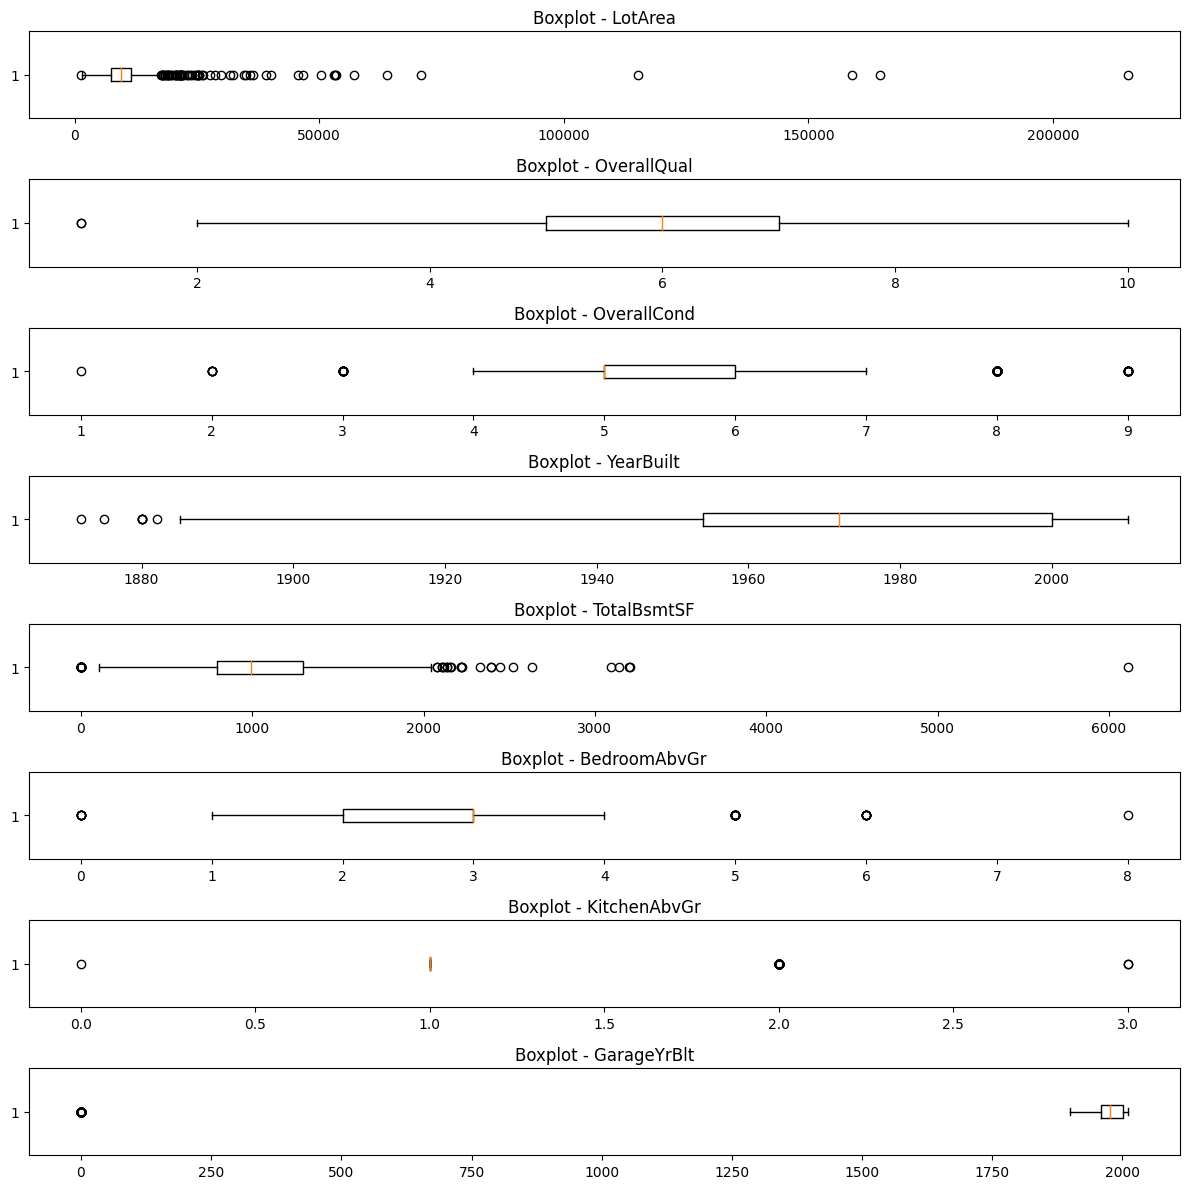

In [13]:
# PLOT BOXPLOT CHART FOR NUMERICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

fig, axs = plt.subplots(len(outlier_numerical_columns), figsize=(12, 12))

for i, column in enumerate(outlier_numerical_columns):
    axs[i].boxplot(df_train_filled[column], vert=False)
    axs[i].set_title(f"Boxplot - {column}")

plt.tight_layout()
plt.show()

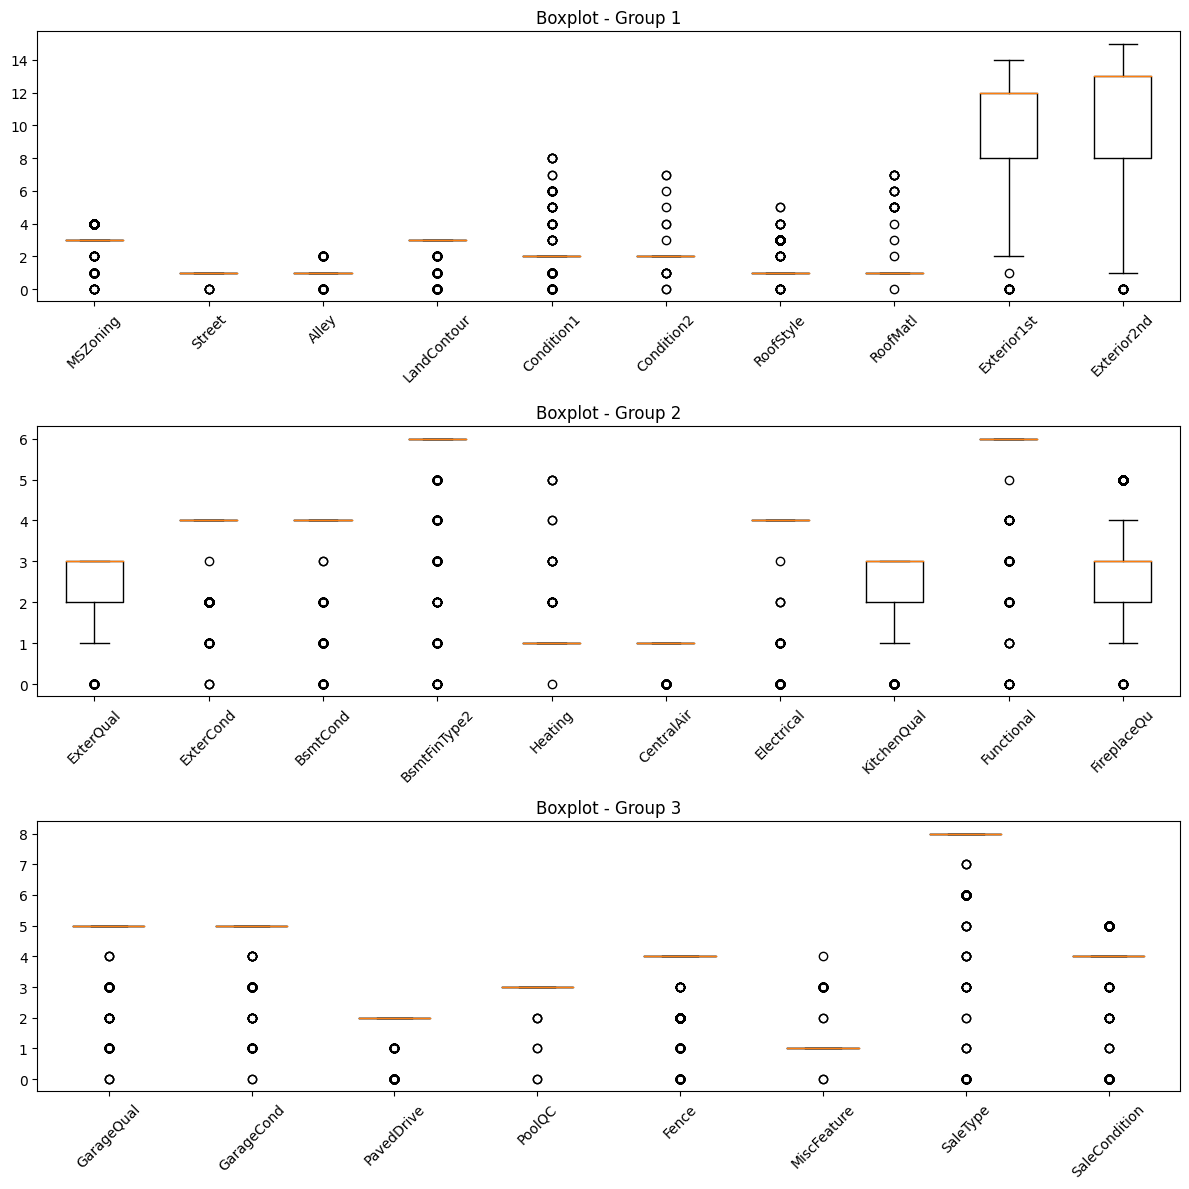

In [14]:
# PLOT BOXPLOT CHART FOR CATEGORICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

num_plots = math.ceil(len(outlier_categorical_columns) / 10)

fig, axs = plt.subplots(num_plots, figsize=(12, 12))

for i in range(num_plots):
    start = i * 10
    end = min((i + 1) * 10, len(outlier_categorical_columns))
    columns_subset = outlier_categorical_columns[start:end]

    if num_plots > 1:
        axs_i = axs[i]
    else:
        axs_i = axs

    axs_i.boxplot(df_train_filled_encoded[columns_subset])
    axs_i.set_xticklabels(columns_subset, rotation=45)
    axs_i.set_title(f"Boxplot - Group {i + 1}")

plt.tight_layout()
plt.show()

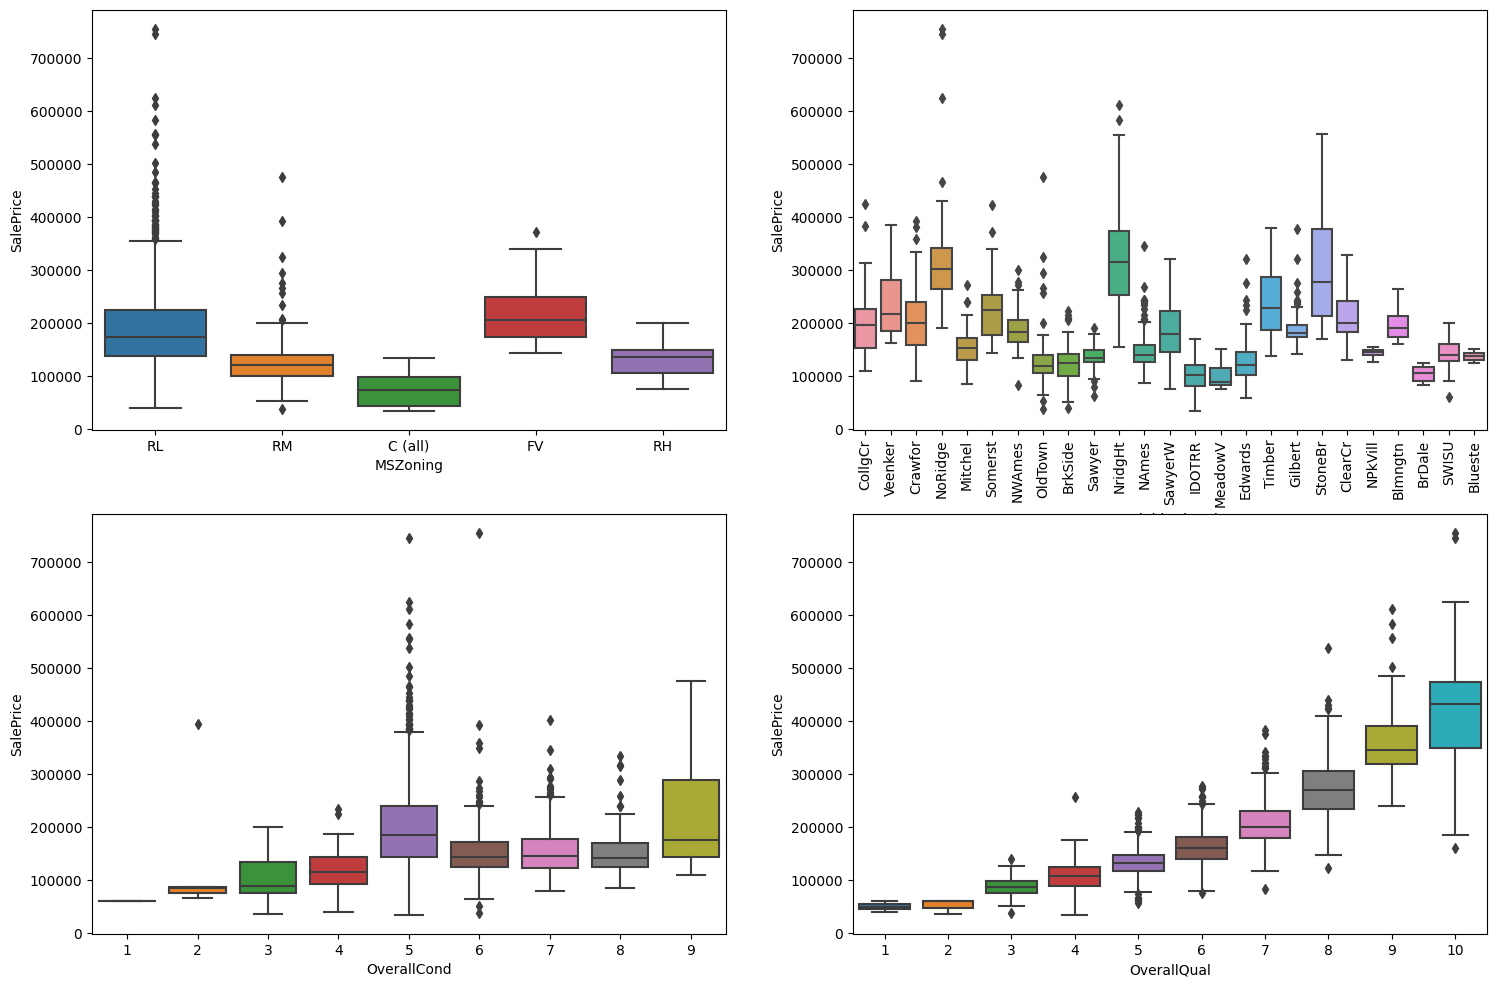

In [15]:
# Analyzing SalePrice columns with others


fig = plt.figure(figsize=(18, 12))

# Chart 1
fig.add_subplot(221)
# sns.countplot(df_train['MSZoning'])
sns.boxplot(x="MSZoning", y="SalePrice", data=df_train)

# Chart 2
fig.add_subplot(222)
# sns.boxplot(x='MSZoning', y='SalePrice', data=df_train)
ax222 = sns.boxplot(x="Neighborhood", y="SalePrice", data=df_train)

# Chart 3
fig.add_subplot(223)
# sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)
sns.boxplot(x="OverallCond", y="SalePrice", data=df_train)

# Chart 4
fig.add_subplot(224)
# sns.violinplot(x = 'OverallQual', y = 'SalePrice', data=df_train, palette='Set3', bw=.2, cut=1, split=True, linewidth=1)
sns.boxplot(x="OverallQual", y="SalePrice", data=df_train)

## Rotate ax222 by 90 degrees
ax222.tick_params(axis="x", labelrotation=90)

2.6) Existem dados faltantes?

Sim. Este item foi respodido na questão 4.

Quatro atributos (colunas) chamam a atenção por ter mais de 80% de dados faltantes (vide destaque em laranja na imagem acima).

In [16]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = df_train.isnull().sum()[df_train.isnull().sum() > 0]
missing_data_percentage = missing_data / len(df_train) * 100

# Combinar as informações em um dataframe
missing_data_df = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
missing_data_df = missing_data_df.sort_values(by="Percentage", ascending=False)

missing_data_df

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


2.7) Em existindo dados faltantes, crie duas novas bases a partir da original, em que não existam dados faltantes usando dois métodos diferentes.

A primeira base já foi criado anteriormente respondendo a questão 4. Chama-se "df_train_filled", onde foi analisado que entre os atributos que possuiam dados faltantes ou N/A alguns poderiam ser substituido por zero, outros por "none" e outros por "not answered". Possibilitando uma tratativa melhor dos dados.

O segundo método é um método simples de exclusão das instâncias que possui alguma variável N/A. O resultado disso é zerar por completo as instâncias da base nova (df_train_na)

In [17]:
df_train_na = df_train.dropna()

df_train_na.info()
df_train_na

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             0 non-null      int64  
 1   MSSubClass     0 non-null      int64  
 2   MSZoning       0 non-null      object 
 3   LotFrontage    0 non-null      float64
 4   LotArea        0 non-null      int64  
 5   Street         0 non-null      object 
 6   Alley          0 non-null      object 
 7   LotShape       0 non-null      object 
 8   LandContour    0 non-null      object 
 9   Utilities      0 non-null      object 
 10  LotConfig      0 non-null      object 
 11  LandSlope      0 non-null      object 
 12  Neighborhood   0 non-null      object 
 13  Condition1     0 non-null      object 
 14  Condition2     0 non-null      object 
 15  BldgType       0 non-null      object 
 16  HouseStyle     0 non-null      object 
 17  OverallQual    0 non-null      int64  
 18  OverallCond    0 non-null  

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


2.8) É possível agregar dados na base? Quais?

Sim, é possível, porém a base de dados já possui vários atributos, tornando a adição desnecessário para a predição do SalePriec.

Uma opção de adição de dados seria o de nível de criminalidade nos bairros das casas ou até mesmo o preechimento dos dados faltantes como foi feito.

2.9) Qual a proporção entre as clases?

Resposta no gráfico abaixo

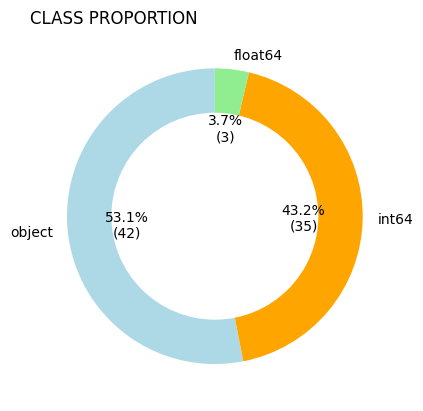

In [18]:
dtypes_count = df_train.dtypes.value_counts()
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ["lightblue", "orange", "lightgreen"]

# CHART
fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sizes.sum())})",
    startangle=90,
)
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)
plt.title("CLASS PROPORTION", loc="left")
plt.show()

2.10) É necessário dimuir a dimensionalidade? Porquê?

Sim, faz-se necessário essa redução ainda mais que algumas variáveis possui pouca correlação com o target do trabalho que é o SalePrice (preço do imóvel). E como visto, algumas colunas?atributos, possuem mais de 90% de dados faltantes, sendo desnecessário ter essas colunas para nossas análises.

2.11) Apresente uma nova base com seleção de atributos usando o algoritmo Relief.

Vide códigos abaixo cujo produto é df_train_relief

In [19]:
# Separar os atributos e o atributo alvo
X = df_train_filled_encoded.drop("SalePrice", axis=1).values
y = df_train_filled_encoded["SalePrice"].values
estimator = LinearRegression()

# Criar o pipeline com o seletor de atributos ReliefF e o regressor RandomForestRegressor
clf = make_pipeline(
    ReliefF(n_features_to_select=10, n_neighbors=200),
    RandomForestRegressor(n_estimators=estimator),
)

# Realizar a seleção de atributos
selector_relief = clf.named_steps["relieff"]
selector_relief.fit(X, y)

# Obtendo os atributos selecionados e seus valores de influência
selected_features_relief = df_train_filled_encoded.drop("SalePrice", axis=1).columns[
    selector_relief.top_features_
]
influence_values_relief = selector_relief.feature_importances_[
    selector_relief.top_features_
]

# Ordenar os atributos pelo valor de influência
sorted_indices = np.argsort(influence_values_relief)[::-1][:10]
selected_features_relief = selected_features_relief[sorted_indices]
influence_values_relief = influence_values_relief[sorted_indices]

# Criando a lista de resultado
result_relief = list(zip(selected_features_relief, influence_values_relief))

# Criar o dataframe df_relief com as colunas selecionadas e a coluna SalePrice
df_train_relief = df_train_filled_encoded[selected_features_relief].copy()
df_train_relief = df_train_relief.join(df_train_filled_encoded["SalePrice"])

In [20]:
result_relief

[('ExterQual', 0.3913628841913529),
 ('GrLivArea', 0.37497866672486224),
 ('KitchenQual', 0.35848858618184753),
 ('BsmtQual', 0.35648083433039013),
 ('OverallQual', 0.34029453406019244),
 ('FullBath', 0.325236413065337),
 ('GarageCars', 0.3165026831730623),
 ('YearBuilt', 0.2675491609785679),
 ('GarageArea', 0.2669449918272386),
 ('1stFlrSF', 0.2663227673577865)]

In [21]:
df_train_relief.head()

,ExterQual,GrLivArea,KitchenQual,BsmtQual,OverallQual,FullBath,GarageCars,YearBuilt,GarageArea,1stFlrSF,SalePrice
0,2,1710,2,2,7,2,2,2003,548,856,208500
1,3,1262,3,2,6,2,2,1976,460,1262,181500
2,2,1786,2,2,7,2,2,2001,608,920,223500
3,3,1717,2,4,7,1,3,1915,642,961,140000
4,2,2198,2,2,8,2,3,2000,836,1145,250000


2.12) Apresente uma nova base com variáveis discretizadas por dois métodos diferentes;

Os dois métodos será aplicados a base df_train_relief.

Os métodos escolhidos foram o Binning (Discretização por Intervalos) e K-Mean.

A primeira base modificada chama-se df_train_relief_binning e a segunda df_train_relief_kmean.

Ambas oriundas de df_train_filled_encoded.

In [22]:
# BINNING METHOD TO DISCRETIZER
# from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")

df_train_relief_binning = df_train_relief.drop(
    "SalePrice", axis=1
)  # Remove a coluna "SalePrice" do dataframe

for column in df_train_relief_binning.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief_binning[column]):
        column_values = df_train_relief_binning[column].values.reshape(-1, 1)
        column_binned = discretizer.fit_transform(column_values)
        df_train_relief_binning[column] = column_binned.flatten()

df_train_relief_binning["SalePrice"] = df_train["SalePrice"]

df_train_relief_binning

,ExterQual,GrLivArea,KitchenQual,BsmtQual,OverallQual,FullBath,GarageCars,YearBuilt,GarageArea,1stFlrSF,SalePrice
0,3.0,1.0,3.0,2.0,3.0,3.0,2.0,4.0,1.0,0.0,208500
1,4.0,0.0,4.0,2.0,2.0,3.0,2.0,3.0,1.0,1.0,181500
2,3.0,1.0,3.0,2.0,3.0,3.0,2.0,4.0,2.0,0.0,223500
3,4.0,1.0,3.0,4.0,3.0,1.0,3.0,1.0,2.0,0.0,140000
4,3.0,1.0,3.0,2.0,3.0,3.0,3.0,4.0,2.0,0.0,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,4.0,1.0,4.0,2.0,2.0,3.0,2.0,4.0,1.0,0.0,175000
1456,4.0,1.0,4.0,2.0,2.0,3.0,2.0,3.0,1.0,1.0,210000
1457,0.0,1.0,3.0,4.0,3.0,3.0,1.0,2.0,0.0,0.0,266500
1458,4.0,0.0,3.0,4.0,2.0,1.0,1.0,2.0,0.0,0.0,142125


In [23]:
df_train_relief_kmean = df_train_relief.copy()

kmeans = KMeans(n_clusters=5, random_state=42)

for column in df_train_relief.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief[column]):
        column_values = df_train_relief[column].values.reshape(-1, 1)
        discretized_values = kmeans.fit_transform(column_values)

        for i in range(discretized_values.shape[1]):
            new_column_name = f"{column}_bin_{i+1}"
            df_train_relief_kmean[new_column_name] = discretized_values[:, i]


df_train_relief_kmean

c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:1093: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight)._transform(X)
c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of

,ExterQual,GrLivArea,KitchenQual,BsmtQual,OverallQual,FullBath,GarageCars,YearBuilt,GarageArea,1stFlrSF,SalePrice,ExterQual_bin_1,ExterQual_bin_2,ExterQual_bin_3,ExterQual_bin_4,ExterQual_bin_5,GrLivArea_bin_1,GrLivArea_bin_2,GrLivArea_bin_3,GrLivArea_bin_4,GrLivArea_bin_5,KitchenQual_bin_1,KitchenQual_bin_2,KitchenQual_bin_3,KitchenQual_bin_4,KitchenQual_bin_5,BsmtQual_bin_1,BsmtQual_bin_2,BsmtQual_bin_3,BsmtQual_bin_4,BsmtQual_bin_5,OverallQual_bin_1,OverallQual_bin_2,OverallQual_bin_3,OverallQual_bin_4,OverallQual_bin_5,FullBath_bin_1,FullBath_bin_2,FullBath_bin_3,FullBath_bin_4,FullBath_bin_5,GarageCars_bin_1,GarageCars_bin_2,GarageCars_bin_3,GarageCars_bin_4,GarageCars_bin_5,YearBuilt_bin_1,YearBuilt_bin_2,YearBuilt_bin_3,YearBuilt_bin_4,YearBuilt_bin_5,GarageArea_bin_1,GarageArea_bin_2,GarageArea_bin_3,GarageArea_bin_4,GarageArea_bin_5,1stFlrSF_bin_1,1stFlrSF_bin_2,1stFlrSF_bin_3,1stFlrSF_bin_4,1stFlrSF_bin_5,SalePrice_bin_1,SalePrice_bin_2,SalePrice_bin_3,SalePrice_bin_4,SalePrice_bin_5
0,2,1710,2,2,7,2,2,2003,548,856,208500,1.0,0.0,2.000000e+00,1.0,0.0,317.373444,1915.611111,744.564477,97.232323,707.375,1.0,1.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1.339207,2.0,0.0,3.22695,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,73.354497,1.173993,45.864865,96.482353,27.916107,267.533724,67.737342,319.343949,81.72482,548.0,73.484305,933.481675,545.523659,1973.636364,212.331276,34270.289796,142675.84466,90752.429066,366292.333333,36224.992537
1,3,1262,3,2,6,2,2,1976,460,1262,181500,0.0,1.0,3.000000e+00,2.0,1.0,130.626556,2363.611111,296.564477,545.232323,1155.375,2.0,0.0,1.0,3.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,2.339207,1.0,1.0,2.22695,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,46.354497,25.826007,18.864865,69.482353,0.916107,179.533724,155.737342,407.343949,6.27518,460.0,479.484305,527.481675,139.523659,1567.636364,193.668724,7270.289796,169675.84466,63752.429066,393292.333333,63224.992537
2,2,1786,2,2,7,2,2,2001,608,920,223500,1.0,0.0,2.000000e+00,1.0,0.0,393.373444,1839.611111,820.564477,21.232323,631.375,1.0,1.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,1.0,1.339207,2.0,0.0,3.22695,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,71.354497,0.826007,43.864865,94.482353,25.916107,327.533724,7.737342,259.343949,141.72482,608.0,137.484305,869.481675,481.523659,1909.636364,148.331276,49270.289796,127675.84466,105752.429066,351292.333333,21224.992537
3,3,1717,2,4,7,1,3,1915,642,961,140000,0.0,1.0,3.000000e+00,2.0,1.0,324.373444,1908.611111,751.564477,90.232323,700.375,1.0,1.0,0.0,2.0,0.0,0.0,2.0,4.0,3.0,1.0,1.0,1.339207,2.0,0.0,3.22695,1.0,0.0,2.0,1.0,0.0,2.0,1.0,0.0,3.0,1.0,14.645503,86.826007,42.135135,8.482353,60.083893,361.533724,26.262658,225.343949,175.72482,642.0,178.484305,828.481675,440.523659,1868.636364,107.331276,34229.710204,211175.84466,22252.429066,434792.333333,104724.992537
4,2,2198,2,2,8,2,3,2000,836,1145,250000,1.0,0.0,2.000000e+00,1.0,0.0,805.373444,1427.611111,1232.564477,390.767677,219.375,1.0,1.0,0.0,2.0,0.0,2.0,0.0,2.0,1.0,1.0,2.0,0.339207,3.0,1.0,4.22695,0.0,1.0,1.0,2.0,1.0,2.0,1.0,0.0,3.0,1.0,70.354497,1.826007,42.864865,93.482353,24.916107,555.533724,220.262658,31.343949,369.72482,836.0,362.484305,644.481675,256.523659,1684.636364,76.668724,75770.289796,101175.84466,132252.429066,324792.333333,5275.007463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1647,3,2,6,2,2,1999,460,953,175000,0.0,1.0,3.000000e+00,2.0,1.0,254.373444,1978.611111,681.564477,160.232323,770.375,2.0,0.0,1.0,3.0,1.0,2.0,0.0,2.0,1.0,1.0,0.0,2.339207,1.0,1.0,2.22695,0.0,1.0,1.0,2.0,1.0,1.0,0.0,1.0,2.0,2.0,69.354497,2.826007,41.864865,92.482353,23.916107,179.533724,155.737342,407.343949,6.27518,460.0,170.484305,836.481675,448.523659,1876.636364,115.331276,770.289796,176175.84466,57252.429066,399792.333333,69724.992537
1456,3,2073,3,2,6,2,2,1978,500,2

In [24]:
# Stats of df_relief
stats_relief = df_train_relief.describe().transpose()
stats_relief.rename(columns=lambda x: f"relief_{x}", inplace=True)

# Stats of df_train_relief_binning
stats_binning = df_train_relief_binning.describe().transpose()
stats_binning.rename(columns=lambda x: f"binning_{x}", inplace=True)

# Stats of df_train_relief_kmean
stats_kmean = df_train_relief_kmean.describe().transpose()
stats_kmean.rename(columns=lambda x: f"kmean_{x}", inplace=True)

# # Comparison between all
# stats_comparison = pd.concat([stats_relief, stats_binning, stats_kmean], axis=1)
# stats_comparison

In [25]:
stats_binning

,binning_count,binning_mean,binning_std,binning_min,binning_25%,binning_50%,binning_75%,binning_max
ExterQual,1451.0,3.498966,0.854501,0.0,3.0,4.0,4.0,4.0
GrLivArea,1451.0,0.603032,0.605348,0.0,0.0,1.0,1.0,4.0
KitchenQual,1451.0,3.247416,1.080287,0.0,3.0,4.0,4.0,4.0
BsmtQual,1451.0,2.729152,1.279158,0.0,2.0,2.0,4.0,4.0
OverallQual,1451.0,2.314266,0.711819,0.0,2.0,2.0,3.0,4.0
FullBath,1451.0,2.108890,1.036172,0.0,1.0,3.0,3.0,4.0
GarageCars,1451.0,1.764990,0.748728,0.0,1.0,2.0,2.0,4.0
YearBuilt,1451.0,3.006203,1.038880,0.0,2.0,3.0,4.0,4.0
GarageArea,1451.0,1.170227,0.775021,0.0,1.0,1.0,2.0,4.0
1stFlrSF,1451.0,0.404549,0.539176,0.0,0.0,0.0,1.0,4.0


In [26]:
stats_kmean

,kmean_count,kmean_mean,kmean_std,kmean_min,kmean_25%,kmean_50%,kmean_75%,kmean_max
ExterQual,1451.0,2.543763,0.691810,0.000000,2.000000,3.000000,3.000000,3.000000
GrLivArea,1451.0,1514.174363,525.799521,334.000000,1128.000000,1464.000000,1776.000000,5642.000000
KitchenQual,1451.0,2.342522,0.829942,0.000000,2.000000,3.000000,3.000000,3.000000
BsmtQual,1451.0,2.729152,1.279158,0.000000,2.000000,2.000000,4.000000,4.000000
OverallQual,1451.0,6.093728,1.381467,1.000000,5.000000,6.000000,7.000000,10.000000
...,...,...,...,...,...,...,...,...
SalePrice_bin_1,1451.0,56238.429297,56270.667244,229.710204,20770.289796,43229.710204,70900.000000,580770.289796
SalePrice_bin_2,1451.0,176732.641673,64361.507269,1175.844660,138725.844660,189675.844660,221675.844660,403824.155340
SalePrice_bin_3,1451.0,70018.635266,73079.463451,247.570934,20747.570934,47252.429066,96252.429066,637252.429066
SalePrice_bin_4,1451.0,394782.467494,76193.683701,8140.666667,360792.333333,412292.333333,444892.333333,539892.333333


In [27]:
stats_relief

,relief_count,relief_mean,relief_std,relief_min,relief_25%,relief_50%,relief_75%,relief_max
ExterQual,1451.0,2.543763,0.691810,0.0,2.0,3.0,3.0,3.0
GrLivArea,1451.0,1514.174363,525.799521,334.0,1128.0,1464.0,1776.0,5642.0
KitchenQual,1451.0,2.342522,0.829942,0.0,2.0,3.0,3.0,3.0
BsmtQual,1451.0,2.729152,1.279158,0.0,2.0,2.0,4.0,4.0
OverallQual,1451.0,6.093728,1.381467,1.0,5.0,6.0,7.0,10.0
FullBath,1451.0,1.562371,0.550301,0.0,1.0,2.0,2.0,3.0
GarageCars,1451.0,1.764990,0.748728,0.0,1.0,2.0,2.0,4.0
YearBuilt,1451.0,1971.092350,30.190266,1872.0,1954.0,1972.0,2000.0,2010.0
GarageArea,1451.0,472.525155,214.171752,0.0,327.5,478.0,576.0,1418.0
1stFlrSF,1451.0,1161.551344,385.002532,334.0,882.0,1086.0,1391.0,4692.0


2.14) Indique os gráficos de dispersão dos atributos.

Resposta no código abaixo.

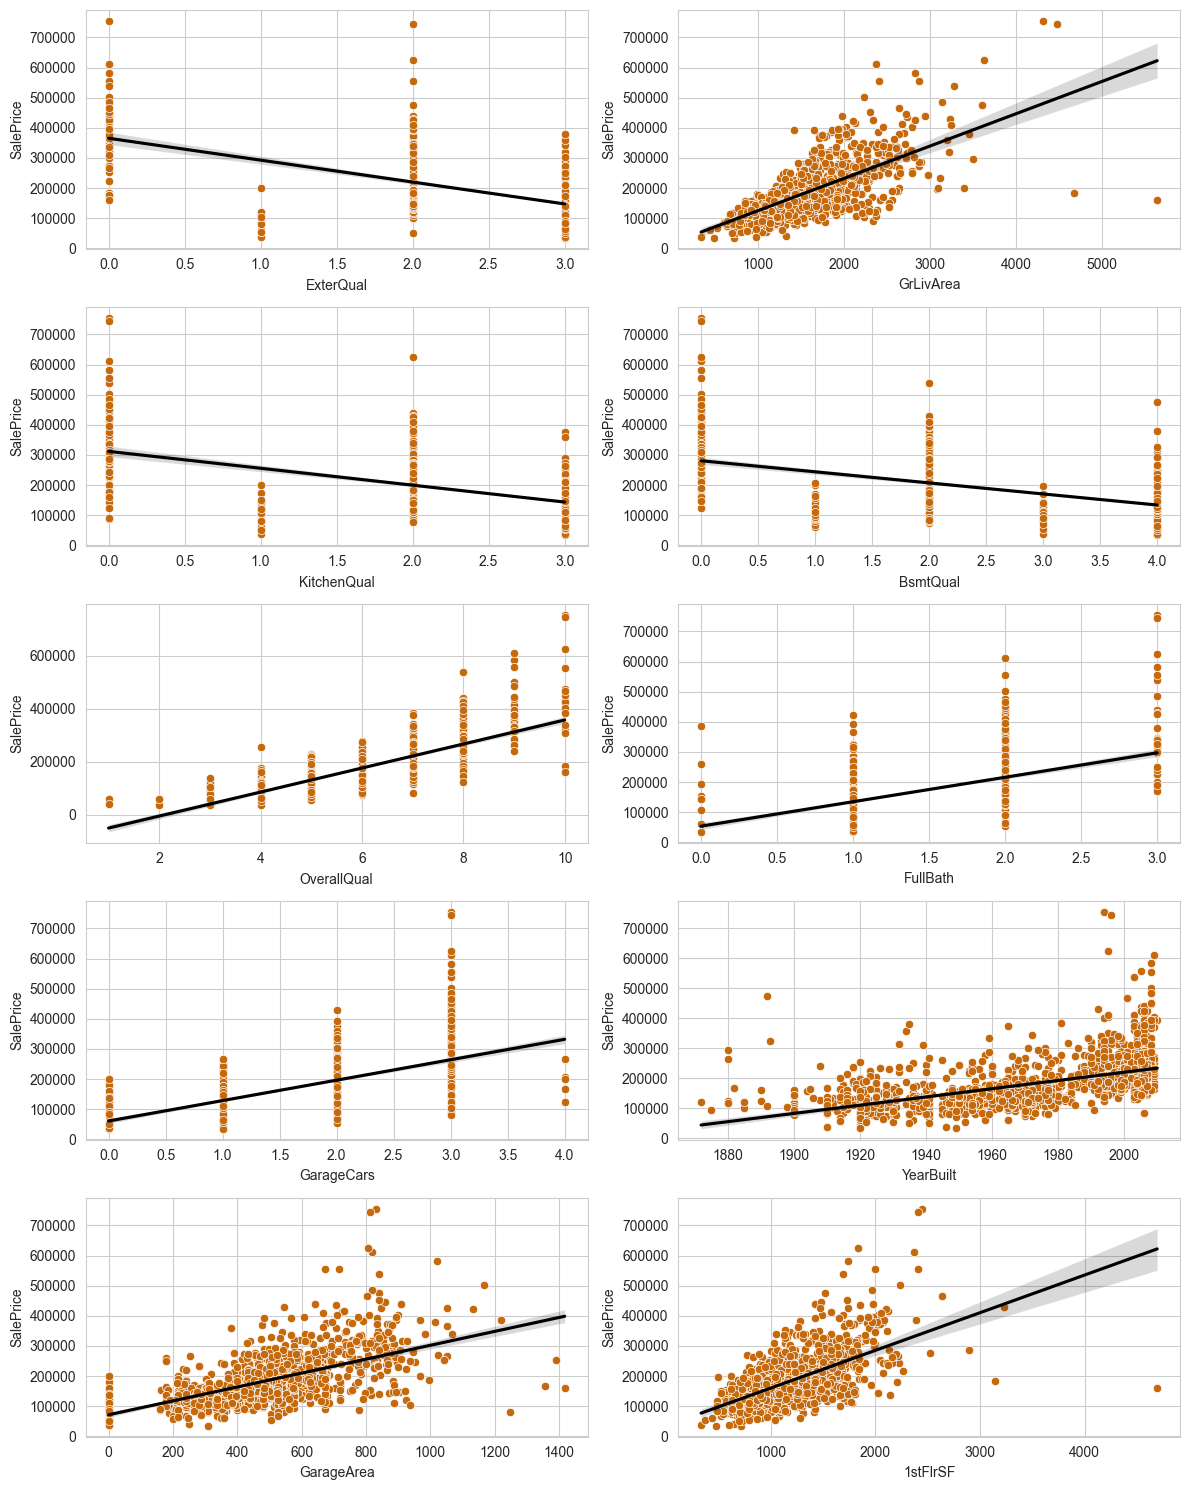

In [28]:
sns.set_palette("PuOr")
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

for i, column in enumerate(df_train_relief.columns):
    if column == "SalePrice":
        continue
    ax = axs[i // 2, i % 2]
    sns.scatterplot(x=column, y="SalePrice", data=df_train_relief, ax=ax)
    sns.regplot(
        x=column,
        y="SalePrice",
        data=df_train_relief,
        ax=ax,
        scatter=False,
        color="black",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("SalePrice")

plt.tight_layout()
plt.show()

# GROUP OF QUESTIONS #3:
# CLASSIFICATION TASK

There are 17 question in this group and each question will be in it own markdown field below.

In [29]:
# carregando os datos de treinamento e validação
train = df_train_relief.copy()
train.head()

,ExterQual,GrLivArea,KitchenQual,BsmtQual,OverallQual,FullBath,GarageCars,YearBuilt,GarageArea,1stFlrSF,SalePrice
0,2,1710,2,2,7,2,2,2003,548,856,208500
1,3,1262,3,2,6,2,2,1976,460,1262,181500
2,2,1786,2,2,7,2,2,2001,608,920,223500
3,3,1717,2,4,7,1,3,1915,642,961,140000
4,2,2198,2,2,8,2,3,2000,836,1145,250000


## Descretizer Sale Price
Explanaition why sale price be discretized

In [30]:
target_variable = "SalePrice"

# Ajustar e transformar os dados de treinamento e teste com MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[[target_variable]])

# Instanciar a classe KBinsDiscretizer com 5 bins (faixas)
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")

# Aplicar o discretizer nos dados 'SalePrice' escalonados
train_preco_discretizado = discretizer.fit_transform(train_scaled)


# Adicionar a nova coluna de categorias ao dataframe original
train["SalePriceCategorical"] = pd.Series(train_preco_discretizado.reshape(-1))


target_variable = "SalePriceCategorical"

# Renomear as categorias
train[target_variable].replace(
    {
        0: "House Price 1",
        1: "House Price 2",
        2: "House Price 3",
        3: "House Price 4",
        4: "House Price 5",
    },
    inplace=True,
)
train.dropna(inplace=True)
train.head()

,ExterQual,GrLivArea,KitchenQual,BsmtQual,OverallQual,FullBath,GarageCars,YearBuilt,GarageArea,1stFlrSF,SalePrice,SalePriceCategorical
0,2,1710,2,2,7,2,2,2003,548,856,208500,House Price 4
1,3,1262,3,2,6,2,2,1976,460,1262,181500,House Price 4
2,2,1786,2,2,7,2,2,2001,608,920,223500,House Price 4
3,3,1717,2,4,7,1,3,1915,642,961,140000,House Price 2
4,2,2198,2,2,8,2,3,2000,836,1145,250000,House Price 5


## ARFF Files - Use in Weka

In [31]:
# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório de arquivos de dados
data_dir = os.path.join(git_dir, "data")

# Definir o diretório onde os arquivos estão localizados
dir = data_dir

# converter dataframe pandas para arquivo arff
pandas2arff(train.drop(columns="SalePrice"), "train.arff", wekaname="train_data")

# Iterar sobre os arquivos no diretório e verificar se a extensão é .arff
arquivos_arff = [arquivo for arquivo in os.listdir(dir) if arquivo.endswith(".arff")]

# Exibir os arquivos encontrados
arquivos_arff

['train.arff']

## Load .arff data

In [32]:
# Inicializar JVM
jvm.start()

# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório de dados de entrada
data_dir = os.path.join(git_dir, "data")

# Diretório de arquivos de saída
output_dir = os.path.join(git_dir, "output")

# Carregar o conjunto de dados
loader = Loader("weka.core.converters.ArffLoader")
train_data = loader.load_file(os.path.join(data_dir, "train.arff"))

# usado para informar ao Weka que a classe é a última coluna do conjunto de dados
train_data.class_is_last()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'c:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'c:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


## C4.5

3.1) Apresentar a árvore de decisão resultante com os parâmetros padrão do classificador

O arquivo da árvore de decisão gerado pelo algoritmo C4.5 encontra-se na pasta "output", nomeado como "c45tree.pdf"

3.2) Analisar a árvore gerada da maneira mais completa possível;

O algoritmo C4.5 é usado para criar árvores de decisão com base em um conjunto de dados rotulados, usando medidas de entropia para determinar o melhor atributo em cada nó da árvore.

Uma árvore de decisão é composta por nós de decisão e folhas. Os nós de decisão são pontos de divisão baseados em atributos, enquanto as folhas representam a classe ou resultado final. A árvore começa com um nó raiz, que abrange todo o conjunto de dados, e se ramifica em nós filhos com base em decisões sucessivas.

A importância dos atributos na árvore de decisão pode ser medida com base na frequência com que aparecem e sua posição na árvore. Atributos que aparecem mais próximos da raiz geralmente têm maior importância, pois são responsáveis ​​por divisões iniciais que afetam a estrutura geral da árvore.

No exemplo fornecido, o nó raiz é o atributo GarageCars, que indica a quantidade de carros. A partir daqui, a árvore de decisão se ramifica em outros nós de decisão com base em atributos como ExterQual e GrLivArea. ExterQual, como mencionado, indica a qualidade do material do exterior da propriedade. GrLivArea, por outro lado, refere-se à área habitável acima do nível do solo, medida em pés quadrados. Esses atributos são escolhidos porque proporcionam o maior ganho de informação e ajudam a reduzir a entropia na árvore de decisão com base no algoritmo.

Cada ramificação subsequente da árvore de decisão é baseada em outros atributos, e o processo continua até que todos os exemplos em cada nó sejam da mesma classe ou não haja mais atributos disponíveis para dividir o conjunto de dados. A árvore de decisão resultante pode então ser usada para classificar novos exemplos, começando pelo nó raiz e seguindo as ramificações apropriadas até chegar a um nó folha, que indica a classe prevista.

In [33]:
# Instanciar o classificador C45
c45 = Classifier(classname="weka.classifiers.trees.J48")

# Treinar o algoritmo usando o conjunto de dados de treinamento
c45.build_classifier(train_data)

# Salvar a árvore em formato .dot
with open(os.path.join(output_dir, "c45tree.dot"), "w") as f:
    f.write(c45.graph)

# Converter o arquivo .dot em um arquivo .pdf
os.system(
    f"dot -Tpdf {os.path.join(output_dir, 'c45tree.dot')} -o {os.path.join(output_dir, 'c45tree.pdf')}"
)

os.remove(os.path.join(output_dir, "c45tree.dot"))

3.3) Indicar qual é a taxa de acerto obtida utilizando o método de validação cruzada com fator 10;

In [34]:
# Avaliar o classificador REPtree usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(c45, train_data, 10, Random(1))

c_4_5_accuracy = round(evaluation.percent_correct, 2)

# Imprimir a taxa de acerto geral do modelo
print(f"Taxa de acerto geral [C4.5]: {c_4_5_accuracy}%")

Taxa de acerto geral [C4.5]: 21.98%


3.4) Apresentar a matriz de confusão;

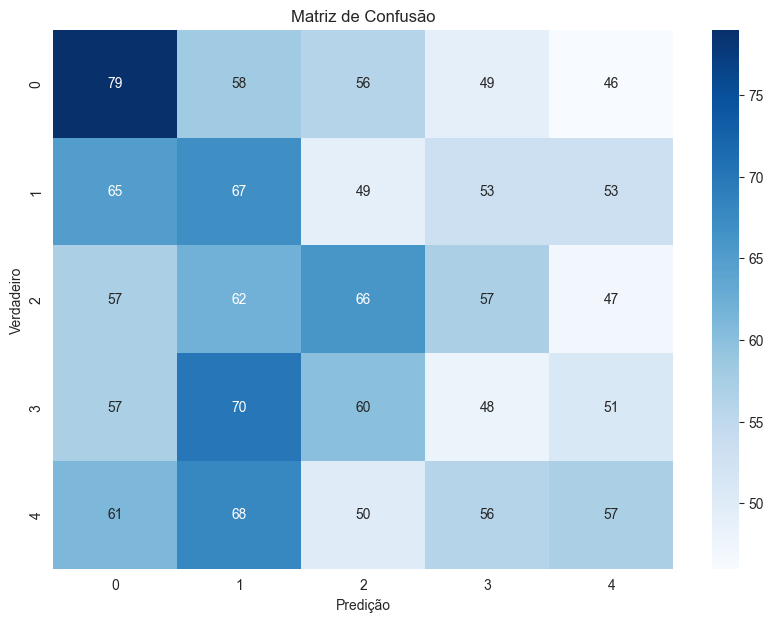

In [35]:
# Obter as previsões do modelo para o conjunto de teste
c45_predictions = evaluation.predictions

# Retonar o dataframe
c45_predictions_df = evaluation_to_dataframe(c45_predictions)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(
    c45_predictions_df["actual"], c45_predictions_df["predicted"]
)

# Criar um gráfico de heatmap com a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

3.5) A partir da matriz de confusão, indicar quais pares de classes são confundidas com mais frequência;

Neste caso, a classe House Price 3 foi confundida com a classe House Price 1 70 vezes e a classe House Price 4 foi confundida com a classe House Price 1 68 vezes. Portanto, os pares de classes (House Price 3, House Price 1) e (House Price 4, House Price 1) são os mais confundidos com frequência.

3.6) Qual a taxa de acerto por classe?

In [36]:
# Calcular as contagens de verdadeiros positivos, falsos positivos e falsos negativos
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Calcular a taxa de acerto para cada classe
accuracy_per_class = true_positives / (
    true_positives + false_positives + false_negatives
)

# Converter a taxa de acerto em um dataframe
accuracy_per_class_df = pd.DataFrame(accuracy_per_class, columns=["Acerto/Classe"])

# Exibir o dataframe com a taxa de acerto por classe
print(accuracy_per_class_df)

   Acerto/Classe
0       0.149621
1       0.122936
2       0.130952
3       0.095808
4       0.116564


## REPTree

In [37]:
# Instanciar o classificador REPtree
reptree = Classifier(classname="weka.classifiers.trees.REPTree")

# Treinar o algoritmo usando o conjunto de dados de treinamento
reptree.build_classifier(train_data)

3.7) Use o algoritmo REPtree para gerar uma árvore de decisão para a base e indique-a

O arquivo da árvore de decisão gerado pelo algoritmo REPTree está localizado na pasta "output" nomeado como "reptree.pdf" 

In [38]:
# Salvar a árvore em formato .dot
with open(os.path.join(output_dir, "reptree.dot"), "w") as f:
    f.write(reptree.graph)

# Converter o arquivo .dot em um arquivo .pdf
os.system(
    f"dot -Tpdf {os.path.join(output_dir, 'reptree.dot')} -o {os.path.join(output_dir, 'reptree.pdf')}"
)

os.remove(os.path.join(output_dir, "reptree.dot"))

3.8) Analise as diferenças entre as árvores geradas.

Embora ambos sejam baseados no conceito de árvores de decisão, eles possuem diferenças significativas em termos de estratégia de divisão, complexidade e desempenho

REPTree:

1. REPTree é um algoritmo de árvore de decisão que constrói árvores de decisão reduzidas de erro (Reduced Error Pruning Tree). Ele é projetado para ser rápido e eficiente.
2. O algoritmo REPTree utiliza a técnica de poda reduzida de erro, em que a árvore é construída com base no conjunto de treinamento e, em seguida, podada utilizando um conjunto de validação separado. A poda reduz a complexidade da árvore e ajuda a evitar o sobreajuste (overfitting).
3. REPTree utiliza a medida de variância para selecionar o melhor atributo para dividir o conjunto de dados em cada nó da árvore.
4. REPTree é mais adequado para problemas de regressão, mas também pode ser usado para classificação.

Na árvore gerada pelo algoritmo REPTree, o nó raiz é baseado no atributo OverallQual, que representa de forma qualitativa o material da propriedade. A partir deste nó raiz, a árvore se ramifica em nós secundários, com base em outros atributos relevantes, como 1stFlrSF e GarageArea

1stFlrSF é um atributo que indica a área habitável acima do solo, medida em pés quadrados. Este atributo é geralmente importante na avaliação do valor de uma propriedade, uma vez que casas com maior área habitável tendem a ser mais valorizadas.

GarageArea refere-se à área total de espaço da garagem, também medida em pés quadrados, o que pode afetar o valor da propriedade e atratividade para potenciais compradores.

A partir desses nós secundários, a árvore de decisão gerada pelo algoritmo REPTree continuará a se ramificar com base em outros atributos relevantes. O objetivo é criar uma árvore de decisão que seja capaz de fazer previsões precisas sobre os dados não vistos, levando em consideração as características mais importantes e informativas do conjunto de dados.

Em comparação com outras árvores de decisão, como as geradas pelo algoritmo C4.5, a árvore criada pelo REPTree tende a ser mais compacta e eficiente devido à técnica de poda reduzida de erro. Isso pode resultar em um modelo que é mais rápido de treinar e tem menor risco de sobreajuste aos dados de treinamento. No entanto, a escolha do algoritmo adequado para gerar árvores de decisão dependerá do problema específico e das necessidades do projeto.

## Ripper

In [39]:
# Instanciar o classificardo Ripper
ripper = Classifier(classname="weka.classifiers.rules.JRip")

# Treinar o algoritmo usando o conjunto de dados de treinamento
ripper.build_classifier(train_data)

3.9) As regras geradas através do uso do algoritmo Ripper;

O arquivo das regras gerado pelo algoritmo Ripper está localizado na pasta "output" nomeado como "ripper_rules.txt" 

In [40]:
# Avaliar o classificador Ripper usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(ripper, train_data, 10, Random(1))

# Salvar as regras em arquivo
with open(os.path.join(output_dir, "ripper_rules.txt"), "w") as f:
    f.write(str(ripper))

3.10) A taxa de acerto geral do item anterior;

In [41]:
# Avaliar o classificador REPtree usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(ripper, train_data, 10, Random(1))

ripper_accuracy = round(evaluation.percent_correct, 2)

# Imprimir a taxa de acerto geral do modelo
print(f"Taxa de acerto geral [Ripper]: {ripper_accuracy}%")

Taxa de acerto geral [Ripper]: 20.25%


3.11) A matriz de confusão resultante do uso do algoritmo Ripper;

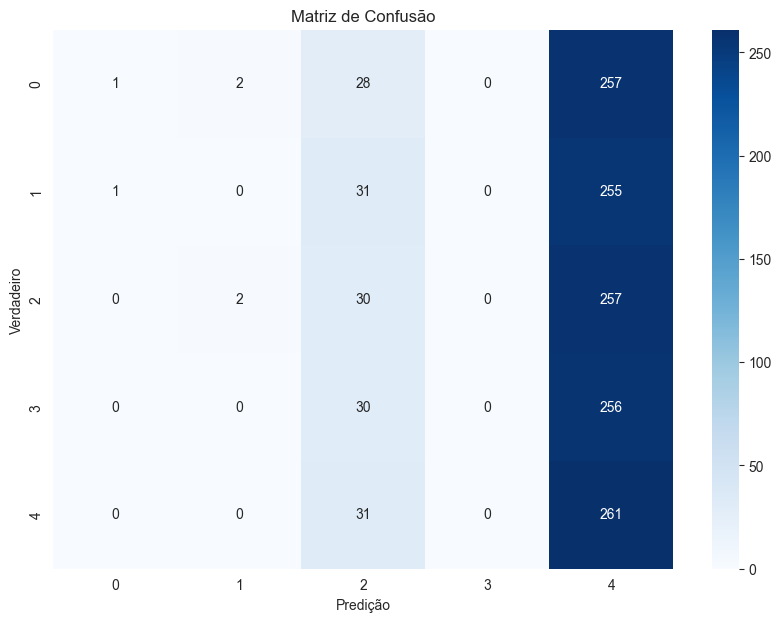

In [42]:
# Obter as previsões do modelo para o conjunto de teste
ripper_predictions = evaluation.predictions

# Retonar o dataframe
ripper_predictions_df = evaluation_to_dataframe(ripper_predictions)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(
    ripper_predictions_df["actual"], ripper_predictions_df["predicted"]
)

# Criar um gráfico de heatmap com a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

## Naive Bayes

In [43]:
# Instanciar o classificador Naive Bayes
naive_bayes = Classifier(classname="weka.classifiers.bayes.NaiveBayes")

# Treinar o algoritmo usando o conjunto de dados de treinamento
naive_bayes.build_classifier(train_data)

3.12) A taxa de acerto geral quando se usa o algoritmo Naive Bayes;

In [44]:
# Avaliar o classificador REPtree usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(naive_bayes, train_data, 10, Random(1))

naive_bayes_accuracy = round(evaluation.percent_correct, 2)

# Imprimir a taxa de acerto geral do modelo
print(f"Taxa de acerto geral [Naive Bayes]: {naive_bayes_accuracy}%")

Taxa de acerto geral [Naive Bayes]: 25.52%


3.13) A matriz de confusão resultante do uso do algoritmo Naive Bayes;

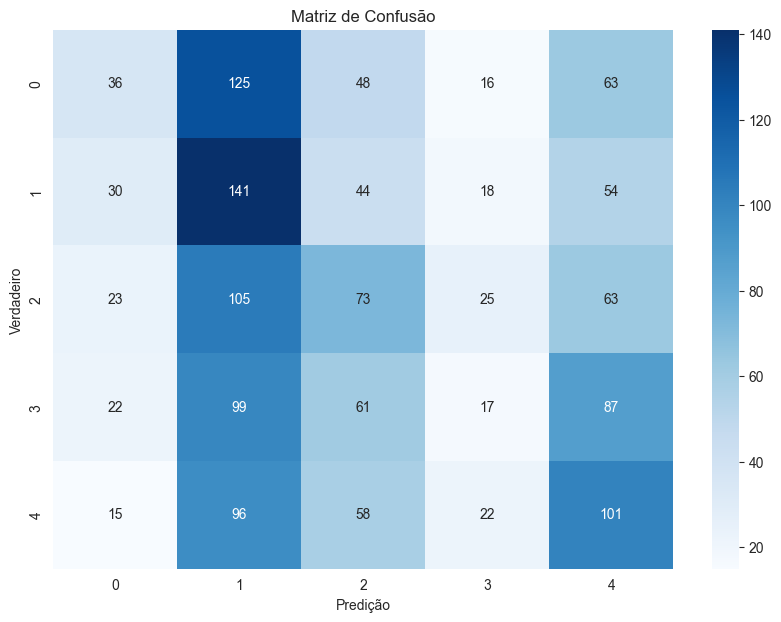

In [45]:
# Obter as previsões do modelo para o conjunto de teste
naive_bayes_predictions = evaluation.predictions

# Retonar o dataframe
naive_bayes_predictions_df = evaluation_to_dataframe(naive_bayes_predictions)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(
    naive_bayes_predictions_df["actual"], naive_bayes_predictions_df["predicted"]
)

# Criar um gráfico de heatmap com a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

## Multilayer Perceptron

In [46]:
# Instanciar o classificador MLP
mlp = Classifier(classname="weka.classifiers.functions.MultilayerPerceptron")

# Treinar o algoritmo usando o conjunto de dados de treinamento
mlp.build_classifier(train_data)

3.14) A taxa de acerto geral quando se usa o algoritmo Multilayer

In [47]:
# Avaliar o classificador MLP usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(mlp, train_data, 10, Random(1))

mlp_accuracy = round(evaluation.percent_correct, 2)

# Imprimir a taxa de acerto geral do modelo
print(f"Taxa de acerto geral [MLP]: {mlp_accuracy}%")

Taxa de acerto geral [MLP]: 22.26%


3.15) A matriz de confusão resultante do uso do algoritmo Multilayer Perceptron;

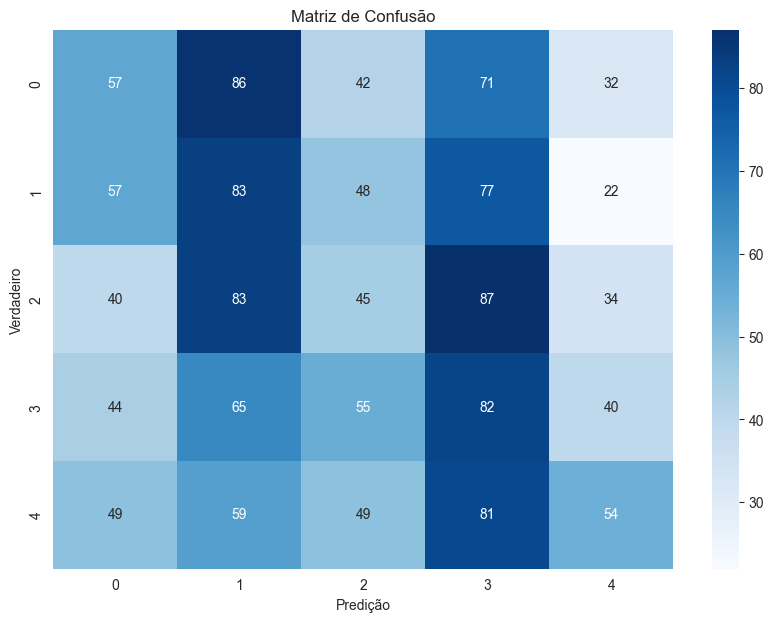

In [48]:
# Obter as previsões do modelo para o conjunto de teste
mlp_predictions = evaluation.predictions

# Adicionar coluna que indica se a previsão foi correta ou não
mlp_predictions_df = evaluation_to_dataframe(mlp_predictions)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(
    mlp_predictions_df["actual"], mlp_predictions_df["predicted"]
)

# Criar um gráfico de heatmap com a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

## K-Nearest Neighbors (KNN)

In [49]:
# Instanciar o classificador KNN
knn_n_1 = Classifier(classname="weka.classifiers.lazy.IBk", options=["-K", "1"])

# Instanciar o classificador KNN
knn_n_5 = Classifier(classname="weka.classifiers.lazy.IBk", options=["-K", "5"])

# Treinar o algoritmo usando o conjunto de dados de treinamento com variavel dependente categorica
knn_n_1.build_classifier(train_data)

# Treinar o algoritmo usando o conjunto de dados de treinamento com variavel dependente categorica
knn_n_5.build_classifier(train_data)

3.16) A taxa de acerto geral obtida com o uso do algoritmo Vizinhos Mais Próximos, com k = 1 e com k = 5;

In [50]:
# Avaliar o classificador KNN usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(knn_n_1, train_data, 10, Random(1))

knn_n_1_accuracy = round(evaluation.percent_correct, 2)

# Imprimir a taxa de acerto geral do modelo
print(f"Taxa de acerto geral [KNN - 1]: {knn_n_1_accuracy}%")

# Avaliar o classificador KNN usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(knn_n_5, train_data, 10, Random(1))

knn_n_5_accuracy = round(evaluation.percent_correct, 2)

# Imprimir a taxa de acerto geral do modelo
print(f"Taxa de acerto geral [KNN - 5]: {knn_n_5_accuracy}%")

Taxa de acerto geral [KNN - 1]: 21.57%
Taxa de acerto geral [KNN - 5]: 22.75%


3.17) Compare os resultados de cada um destes algoritmos com aqueles obtidos com árvore de decisão e apresente suas conclusões, justificando-as.

As taxas de acerto de todos os algoritmos testados estão bem parecidas, variando entre 20% e 25%. Essa similaridade na performance sugere que não há uma justificativa forte para a escolha de um algoritmo específico nesse caso. É importante destacar que essa taxa de acerto pode ser explicada pelo fato de que o problema em questão envolve regressão e não classificação. Algoritmos de classificação, por exemplo, podem ter uma performance consideravelmente melhor em problemas de classificação.

Outro ponto importante a ser considerado é a ausência de um pré-processamento de dados de entrada exaustivo. A qualidade dos dados de entrada tem um impacto significativo na qualidade das previsões do modelo. O princípio de "garbage-in, garbage-out" sugere que se os dados de entrada não forem adequadamente processados e limpos, o modelo resultante também será de baixa qualidade.

Foi testada também a redução de dimensionalidade utilizando o algoritmo ReliefF, que seleciona os atributos mais importantes para o problema em questão. No entanto, mesmo com essa abordagem, a taxa de acerto não ultrapassou a faixa mencionada anteriormente. Isso indica que, para melhorar a performance dos modelos, pode ser necessário explorar outras técnicas de pré-processamento, seleção de atributos ou até mesmo testar outros algoritmos de aprendizado de máquina mais adequados ao problema de regressão.

Além disso, a otimização de hiperparâmetros dos algoritmos e a validação cruzada podem ser exploradas para melhorar ainda mais a performance dos modelos e garantir a estabilidade das previsões. Essas abordagens podem ajudar a encontrar a melhor configuração possível para os algoritmos em questão e garantir uma melhor generalização para os dados não vistos.